In [1]:
CUDA_INDEX = 0
NAME = 'GED_Mutagenicity'
CLASSES = 14

In [2]:
import sys
sys.path.insert(0, '..')
sys.path.insert(0, '../..')
sys.path.insert(0, '../../pyged/lib')


In [3]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
torch.cuda.set_device(CUDA_INDEX)
torch.backends.cudnn.benchmark = True
import torch.optim
import torch_geometric as tg
import torch_geometric.data
from tqdm.auto import tqdm

from neuro import config, datasets, metrics, models, train, utils, viz
import pyged

from importlib import reload
import random

reload(config)
reload(datasets)
reload(metrics)
reload(models)
reload(pyged)
reload(train)
reload(utils)
reload(viz)

/home/nyati_pranav26/Pranav/gnn-x-experiments/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'neuro.viz' from '/home/nyati_pranav26/Pranav/gnn-x-experiments/GREED/greed/nbs_train/../neuro/viz.py'>

In [4]:

# train_1 = torch.load(f'../data/{NAME}/train_40k.pt', map_location='cpu')
# train_2 = torch.load(f'../data/{NAME}/train_40k_part2.pt', map_location='cpu')

# queries1, targets1, lb1, ub1 = train_1
# queries2, targets2, lb2, ub2 = train_2

# queries_total = queries1 + queries2
# targets_total = targets1 + targets2
# # concatenate the lower and upper bounds
# lb_total = torch.cat((lb1, lb2))
# ub_total = torch.cat((ub1, ub2))

# train_set_total = (queries_total, targets_total, lb_total, ub_total)
# # # shuffle the train set
# # # train_set_total = random.shuffle(train_set_total)
# # # save the train set
# torch.save(train_set_total, f'../data/{NAME}/train.pt')


# file1 = open(f'../data/{NAME}/train_1.txt', 'w')
# file2 = open(f'../data/{NAME}/train_2.txt', 'w')

# print("TRAIN SET 1:", file=file1)
# print("Len of train_1:", len(queries1), file=file1)
# for i in range(5):
#     print(f"Query {i}:", file=file1)    
#     print("Num nodes:", queries1[i].num_nodes, "Num edges:", queries1[i].num_edges, file=file1)
#     print("Graph node shape:", queries1[i].x.shape, file=file1)
#     # print("Graph nodes:", queries1[i].x, "Graph edges:", queries1[i].edge_index, file=file1)
    
#     print(f"Target {i}:", file=file1)
#     print("Num nodes:", targets1[i].num_nodes, "Num edges:", targets1[i].num_edges, file=file1)
#     print("Graph node shape:", targets1[i].x.shape, file=file1, flush=True)
#     # print("Graph nodes:", targets1[i].x, "Graph edges:", targets1[i].edge_index, file=file1)
#     print("GED lower bound:", lb1[i], "GED upper bound:", ub1[i], file=file1)
    
# print("\n", file=file1)
# for i in range(5):
#     back_i = len(queries1) - i - 1
#     print(f"Query {back_i}:", file=file1)
#     print("Num nodes:", queries1[back_i].num_nodes, "Num edges:", queries1[back_i].num_edges, file=file1)
#     print("Graph node shape:", queries1[back_i].x.shape, file=file1)
#     # print("Graph nodes:", queries1[back_i].x, "Graph edges:", queries1[back_i].edge_index, file=file1)
    
#     print(f"Target {back_i}:", file=file1)
#     print("Num nodes:", targets1[back_i].num_nodes, "Num edges:", targets1[back_i].num_edges, file=file1)
#     print("Graph node shape:", targets1[back_i].x.shape, file=file1, flush=True)
#     # print("Graph nodes:", targets1[back_i].x, "Graph edges:", targets1[back_i].edge_index, file=file1)
#     print("GED lower bound:", lb1[back_i], "GED upper bound:", ub1[back_i], file=file1)
    
    
# print("TRAIN SET 2:", file=file2)
# print("Len of train_2:", len(queries2), file=file2)
# for i in range(5):
#     print(f"Query {i}:", file=file2)
#     print("Num nodes:", queries2[i].num_nodes, "Num edges:", queries2[i].num_edges, file=file2)
#     print("Graph node shape:", queries2[i].x.shape, file=file2)
#     # print("Graph nodes:", queries2[i].x, "Graph edges:", queries2[i].edge_index, file=file2)
    
#     print(f"Target {i}:", file=file2)
#     print("Num nodes:", targets2[i].num_nodes, "Num edges:", targets2[i].num_edges, file=file2)
#     print("Graph node shape:", targets2[i].x.shape, file=file2, flush=True)
#     # print("Graph nodes:", targets2[i].x, "Graph edges:", targets2[i].edge_index, file=file2)
#     print("GED lower bound:", lb2[i], "GED upper bound:", ub2[i], file=file2)
    
# for i in range(5):
#     back_i = len(queries2) - i - 1
#     print(f"Query {back_i}:", file=file2)
#     print("Num nodes:", queries2[back_i].num_nodes, "Num edges:", queries2[back_i].num_edges, file=file2)
#     print("Graph node shape:", queries2[back_i].x.shape, file=file2)
#     # print("Graph nodes:", queries2[back_i].x, "Graph edges:", queries2[back_i].edge_index, file=file2)
    
#     print(f"Target {back_i}:", file=file2)
#     print("Num nodes:", targets2[back_i].num_nodes, "Num edges:", targets2[back_i].num_edges, file=file2)
#     print("Graph node shape:", targets2[back_i].x.shape, file=file2, flush=True)
#     # print("Graph nodes:", targets2[back_i].x, "Graph edges:", targets2[back_i].edge_index, file=file2)
    
#     print("GED lower bound:", lb2[back_i], "GED upper bound:", ub2[back_i], file=file2)

In [5]:
train_set = torch.load(f'../data/{NAME}/train.pt', map_location='cpu')
queries, targets, lb, ub = train_set

print("Num of queries:", len(queries))
print("Num of targets:", len(targets))
print("Num of lb:", len(lb))
print("Num of ub:", len(ub))

Num of queries: 80000
Num of targets: 80000
Num of lb: 80000
Num of ub: 80000


In [6]:
nodes= [h.num_nodes for h in train_set[1]]
edges = [h.num_edges for h in train_set[1]]
print(f"avg target nodes: {sum(nodes)/len(nodes):.3f}")
print(f"avg target edges: {sum(edges)/len(edges):.3f}")

avg target nodes: 28.471
avg target edges: 58.988


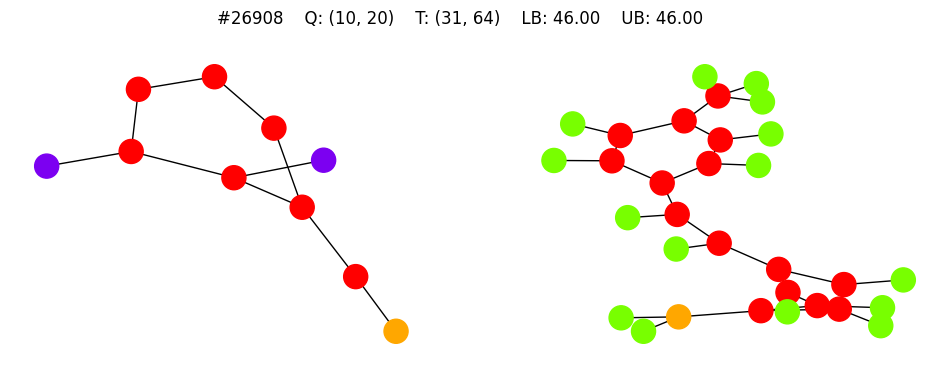

---

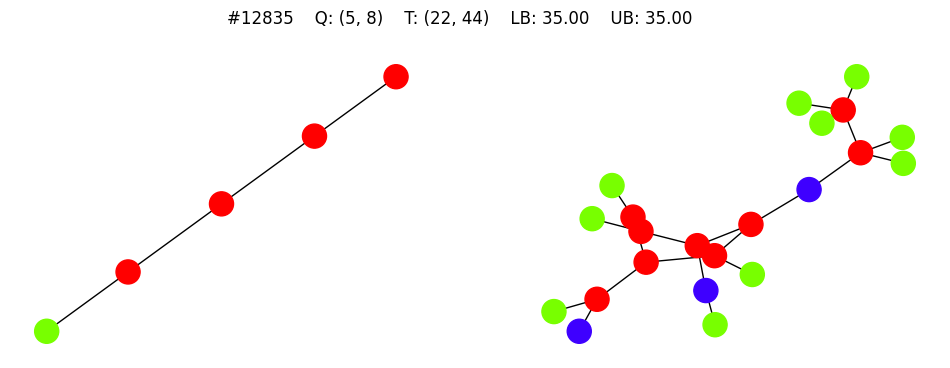

---

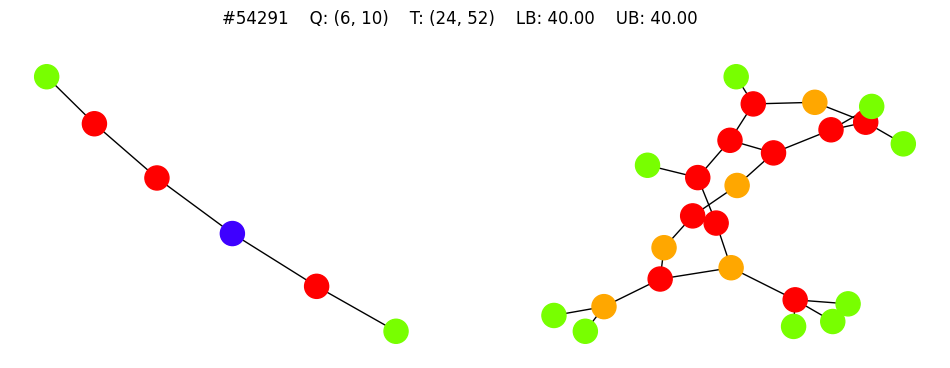

---

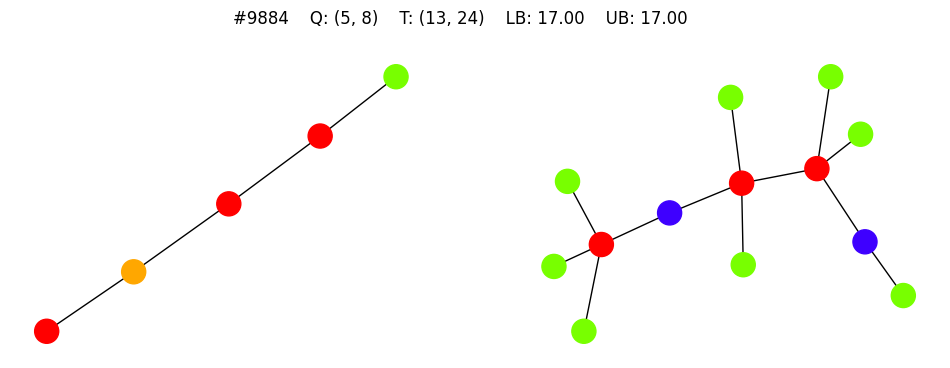

---

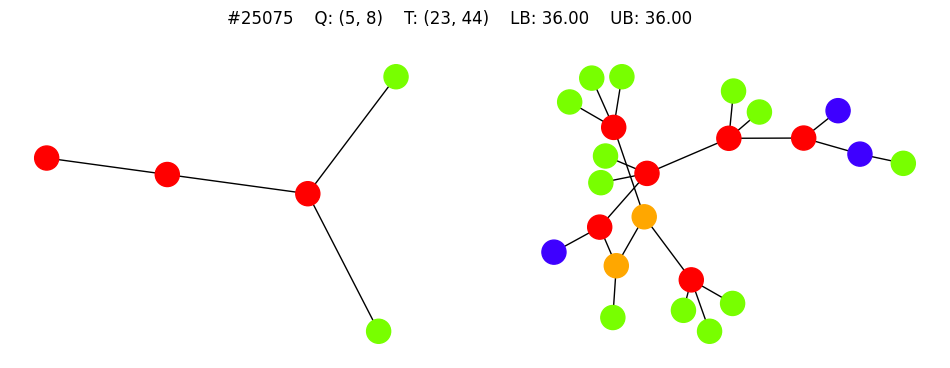

---

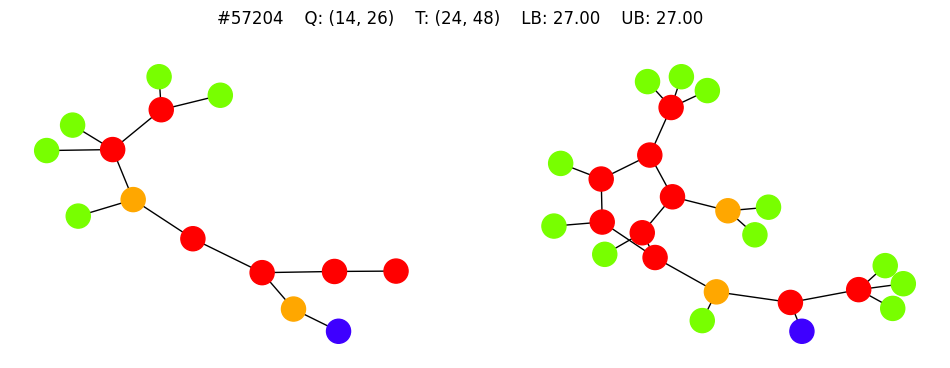

---

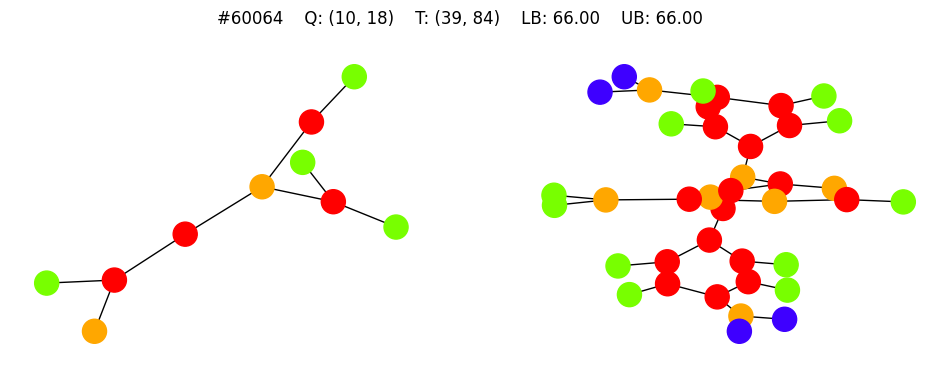

---

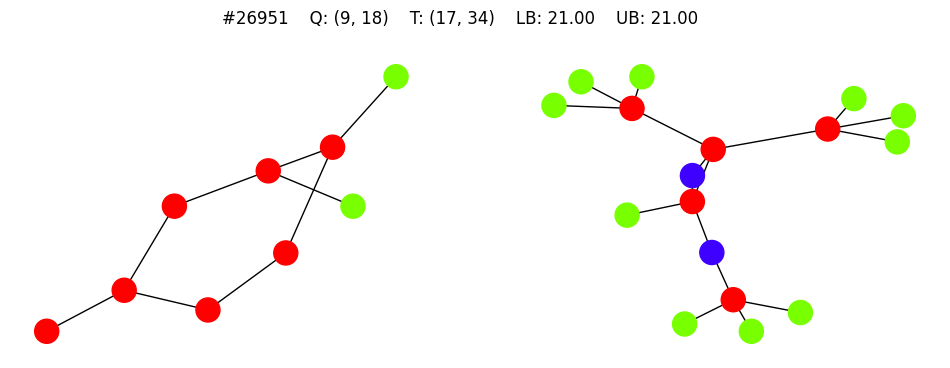

---

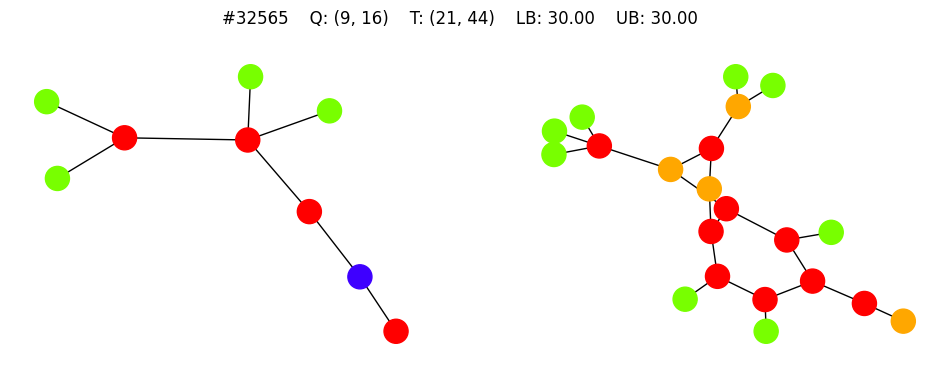

---

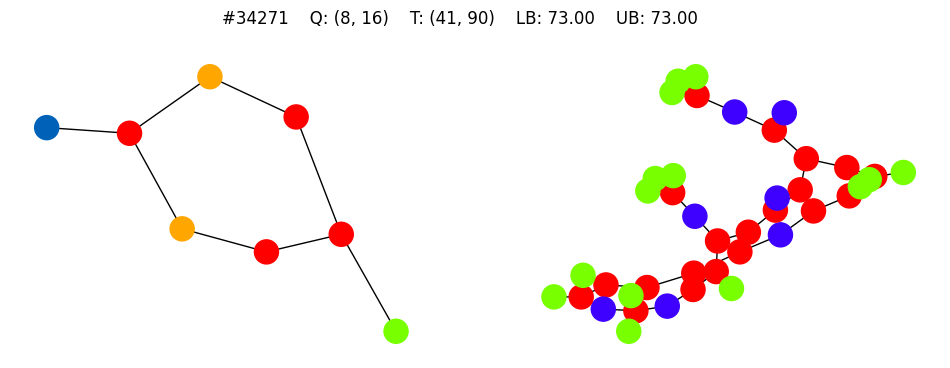

---

In [7]:
viz.plot_inner_dataset(train_set, n_items=10, random=True)

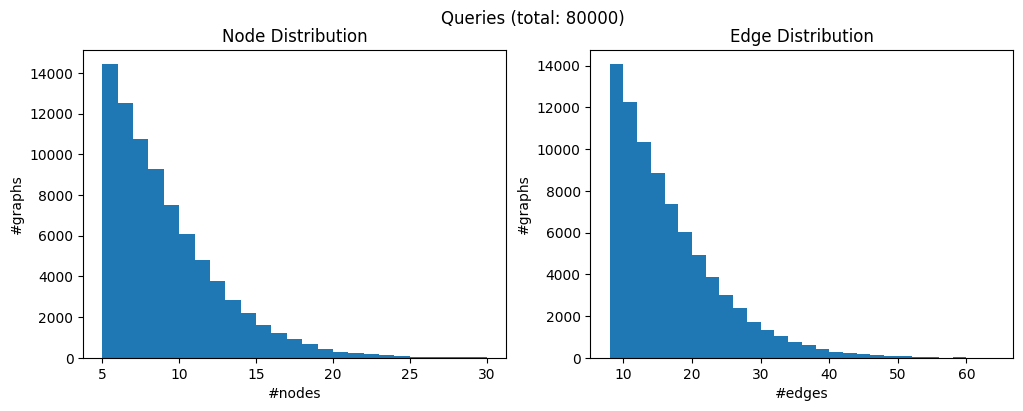

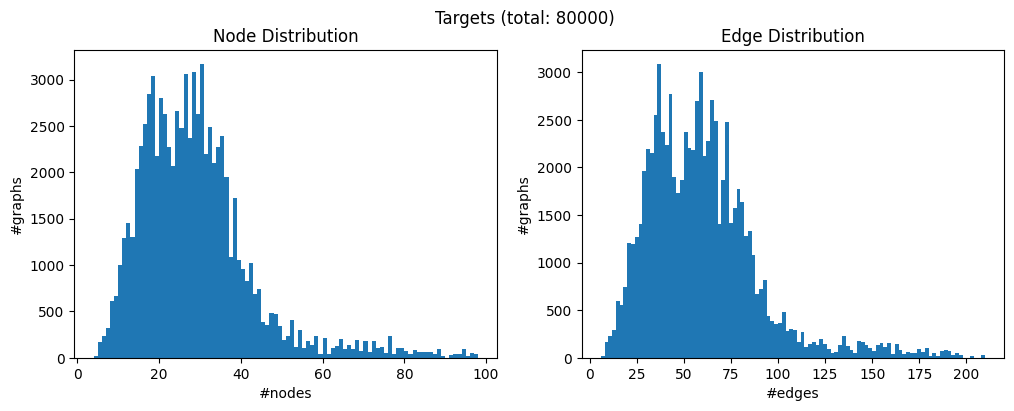

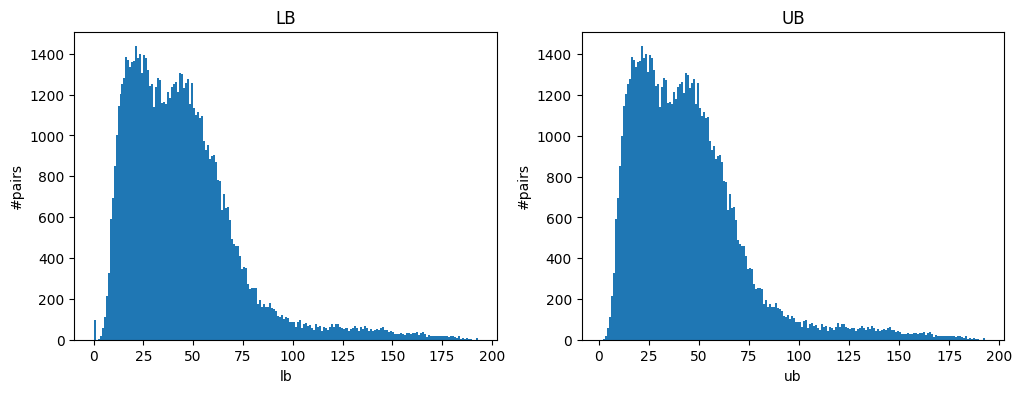

In [8]:
viz.plot_dataset_dist(train_set)

/home/nyati_pranav26/Pranav/gnn-x-experiments/GREED/greed/nbs_train/../neuro/viz.py:229: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x = x//bin_size*bin_size


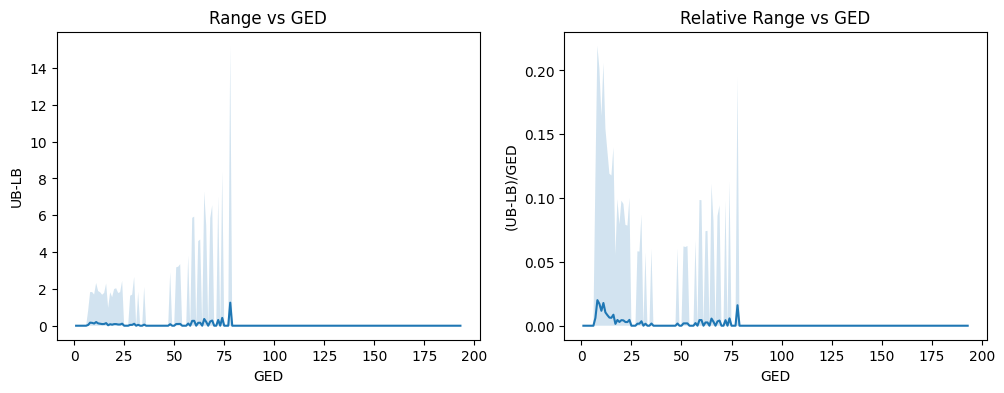

In [9]:
queries, targets, lb, ub = train_set
sed = (lb+ub)/2
plt.figure(figsize=(12,4))
plt.subplot(121)
viz.plot_corr(sed, ub-lb, show_std=True)
plt.xlabel('GED')
plt.ylabel('UB-LB')
plt.title('Range vs GED')
plt.subplot(122)
viz.plot_corr(sed, (ub-lb)/sed, show_std=True)
plt.xlabel('GED')
plt.ylabel('(UB-LB)/GED')
plt.title('Relative Range vs GED')
plt.show()

In [10]:
val_set = torch.load(f'../data/{NAME}/val.pt', map_location='cpu')

In [11]:
model = models.NormGEDModel(8, CLASSES, 64, 64).to(config.device)

In [12]:
train_loader = tg.data.DataLoader(list(zip(*train_set)), batch_size=200, shuffle=True)
val_loader = tg.data.DataLoader(list(zip(*val_set)), batch_size=1000, shuffle=True)

/home/nyati_pranav26/Pranav/gnn-x-experiments/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [13]:
dump_path = os.path.join(f'../runlogs/{NAME}', str(time.time()))
if not os.path.exists(dump_path):
    os.makedirs(dump_path)
    
train.train_full(model, train_loader, val_loader, lr=1e-3, weight_decay=1e-3, cycle_patience=5, step_size_up=2000, step_size_down=2000, dump_path=dump_path)

dump path: ../runlogs/GED_Mutagenicity/1711166949.8834667


: 